In [1]:
import rebound
import reboundx
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
try:
    plt.style.use('paper')
except:
    pass

In [13]:
def makesim(eps_J2=0., e=1.e-2, dtfac=0.01, integrator="whfast"):
    sim = rebound.Simulation()
    sim.G = 4*np.pi**2
    sim.add(m=1.)
    sim.add(m=3.e-6, a=1., e=e)
    sim.add(m=3.e-6, a=2., e=e)
    sim.move_to_com()
    sim.integrator=integrator
    sim.dt = dtfac*sim.particles[1].P
    
    rebx = reboundx.Extras(sim)
    gh = rebx.load_force("gravitational_harmonics")
    rebx.add_force(gh)
    ps = sim.particles
    ps[0].params['R_eq'] = ps[1].a
    ps[0].params['J2'] = 2*eps_J2 # eps = 1/2 J2 (r/a)**2
    return sim, rebx, gh

In [10]:
def run(times, eps_J2=0., e=1.e-2, dtfac=0.01, tmax=1.e3, integrator="whfast"):
    sim, rebx, gh = makesim(eps_J2=eps_J2, e=e, dtfac=dtfac, integrator=integrator)
    E0 = sim.calculate_energy() + rebx.gravitational_harmonics_hamiltonian()
    Es = np.zeros(Nout)
    for i, time in enumerate(times):
        sim.integrate(time)
        E = sim.calculate_energy() + rebx.gravitational_harmonics_hamiltonian()
        Es[i] = np.abs((E-E0)/E0)
    return Es

In [4]:
%%time

tmax = 1.e4
e=1.e-2
eps_J2 = 1.e-3
dtfac = 1.e-2

Nout = 1000
times = np.logspace(0, np.log10(tmax), Nout)
Nes = 100
es = np.logspace(-5, -1, Nes)

ELF, EWH = np.zeros(Nes), np.zeros(Nes)
for i, e in enumerate(es):
    EsLF = run(times=times, eps_J2=eps_J2, e=e, dtfac=dtfac, tmax=tmax, integrator="leapfrog")
    ELF[i] = np.max(EsLF)
    EsWH = run(times=times, eps_J2=eps_J2, e=e, dtfac=dtfac, tmax=tmax, integrator="whfast")
    EWH[i] = np.max(EsWH)

CPU times: user 1min 56s, sys: 24.6 ms, total: 1min 56s
Wall time: 1min 56s


In [14]:
%%time
e=1.e-2
EsWH = run(times=times, eps_J2=eps_J2, e=e, dtfac=dtfac, tmax=tmax, integrator="whfast")
EsLF = run(times=times, eps_J2=eps_J2, e=e, dtfac=dtfac, tmax=tmax, integrator="leapfrog")

CPU times: user 1.19 s, sys: 3.96 ms, total: 1.2 s
Wall time: 1.2 s


/home/dtamayo/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: MaxNLocator.set_params got an unexpected parameter: numticks
  del sys.path[0]


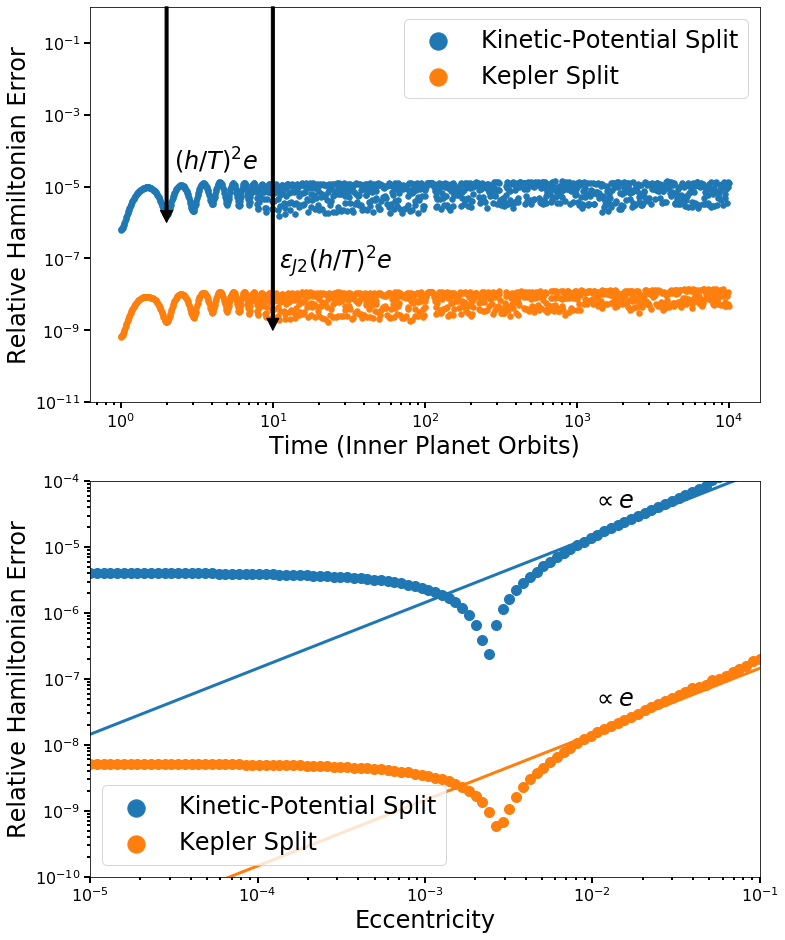

In [16]:
eps_p = 3.e-6
s = 30
fig, axarr = plt.subplots(nrows=2, figsize=(12,16))
ax = axarr[0]
ax.scatter(times, EsLF, s=s, label='Kinetic-Potential Split')
ax.scatter(times, EsWH, s=s, label='Kepler Split')

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim([1.e-11, 1.])

plt.rcParams["text.usetex"] = False
plt.locator_params(axis='y', numticks=5)

ax.annotate(s='', xy=(2, e*dtfac**2), xytext=(2, 1), arrowprops=dict(width=3, facecolor='black'))
ax.annotate(s='', xy=(10, e*eps_J2*dtfac**2), xytext=(10, 1), arrowprops=dict(width=3, facecolor='black'))

ax.text(2.25, 3.e-5, r'$(h/T)^2e$', fontsize=24)
ax.text(11, 5.e-8, r'$\epsilon_{J2}(h/T)^2e$', fontsize=24)

ax.set_xlabel('Time (Inner Planet Orbits)', fontsize=24)
ax.set_ylabel('Relative Hamiltonian Error', fontsize=24)

lgnd = ax.legend(fontsize=24,loc='upper right', scatterpoints=1)
for handle in lgnd.legendHandles:
    handle.set_sizes([300])
    
ax1 = axarr[1]
mid = int(3*Nes/4)
ax1.scatter(es, ELF, label='Kinetic-Potential Split')
ax1.scatter(es, EWH, label='Kepler Split')
ax1.plot(es, ELF[mid]*es/es[mid])
ax1.plot(es, EWH[mid]*es/es[mid])
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlabel('Eccentricity', fontsize=24)
ax1.set_ylabel('Relative Hamiltonian Error', fontsize=24)
ax1.set_ylim([1.e-10, 1.e-4])
ax1.set_xlim([1.e-5, 1.e-1])

ax1.text(1.e-2, 4.e-5, r'$\propto e$', fontsize=24)
ax1.text(1.e-2, 4.e-8, r'$\propto e$', fontsize=24)

lgnd = ax1.legend(fontsize=24,loc='lower left', scatterpoints=1)
for handle in lgnd.legendHandles:
    handle.set_sizes([300])

fig.savefig("fig2.pdf", bbox_inches='tight')